# Class-Conditional Generation with Classifier-Free Guidance

In the previous notebooks, we built generative models that produce **random** digits. We had no control over *which* digit gets generated - the model samples from the entire data distribution.

In this notebook, we add **class conditioning** - the ability to say "generate a 7" and actually get a 7!

## The Conditional Generation Problem

Mathematically, we're moving from **unconditional** to **conditional** generation:

| Previous Notebooks | This Notebook |
|---------|-------------|
| $p(x)$ | $p(x \mid y)$ |
| Generate any digit | Generate digit of class $y$ |

The key insight: instead of learning the marginal distribution $p(x)$, we learn the **conditional distribution** $p(x \mid y)$ where $y \in \{0, 1, \ldots, 9\}$ is the digit class.

## From Class Labels to Text Prompts

Class conditioning is a **stepping stone** to text conditioning. The principles are identical:

| Application | Condition $y$ | Distribution |
|-------------|---------------|--------------|
| This notebook | Digit class (0-9) | $p(x \mid y = \text{digit})$ |
| Stable Diffusion | Text prompt | $p(x \mid y = \text{prompt})$ |
| DALL-E | Text description | $p(x \mid y = \text{text})$ |

## Mathematical Framework

We modify our flow matching objective to be conditioned on class $y$:

**Unconditional (previous notebooks):**
$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t} \left[ \| v_\theta(x_t, t) - (x_1 - x_0) \|^2 \right]$$

**Conditional (this notebook):**
$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t, y} \left[ \| v_\theta(x_t, t, y) - (x_1 - x_0) \|^2 \right]$$

The velocity field $v_\theta$ now takes the class label $y$ as an additional input.

## What We'll Learn

1. **Class Embeddings**: Convert discrete labels to continuous vectors via $e: \{0, \ldots, 9\} \to \mathbb{R}^D$
2. **Conditioning Mechanism**: How to inject class information into the model
3. **Classifier-Free Guidance (CFG)**: Amplify conditioning at inference time
4. **Label Dropout**: Training technique that enables CFG

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Set up device
from from_noise_to_images import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## 1. Class Embeddings: From Discrete Labels to Continuous Vectors

Our class labels are integers: $y \in \{0, 1, 2, \ldots, 9\}$. But neural networks operate on continuous vectors. How do we bridge this gap?

### The Embedding Function

We define an **embedding function** $e: \mathcal{Y} \to \mathbb{R}^D$ that maps each class to a learnable vector:

$$e(y) = W_e[y] \in \mathbb{R}^D$$

where:
- $\mathcal{Y} = \{0, 1, \ldots, K-1\}$ is the set of $K$ classes
- $W_e \in \mathbb{R}^{K \times D}$ is a learnable **embedding matrix**
- $W_e[y]$ denotes the $y$-th row of $W_e$

For MNIST with $K=10$ classes and embedding dimension $D=1024$:

$$W_e = \begin{bmatrix} 
- & e_0 & - \\
- & e_1 & - \\
& \vdots & \\
- & e_9 & -
\end{bmatrix} \in \mathbb{R}^{10 \times 1024}$$

Each row $e_i$ is the learnable embedding for digit $i$.

### Why Embeddings Work

Embedding tables are universal in deep learning (word embeddings, token embeddings, etc.). They work because:

1. **Gradient Flow**: Each $e_i$ receives gradients only when class $i$ is used, learning class-specific features
2. **Representation Learning**: The network learns to place similar classes near each other in embedding space
3. **Flexibility**: Unlike one-hot encodings, embeddings can capture relationships between classes

### The Null Class: Enabling Classifier-Free Guidance

For CFG (explained in Section 3), we need a special **null class** $\emptyset$ representing "no conditioning":

$$\mathcal{Y}_{\text{extended}} = \{0, 1, \ldots, K-1, \emptyset\}$$

This gives us $K+1 = 11$ embeddings total. The null embedding $e_\emptyset$ is learned during training and represents the "unconditional" case.

**Implementation**: We use index $K$ (i.e., 10) for the null class:

$$e_\emptyset = W_e[K] = W_e[10]$$

Embedding table shape: torch.Size([11, 1024])
  - 11 classes (10 digits + 1 null class)
  - 1024 dimensions per class


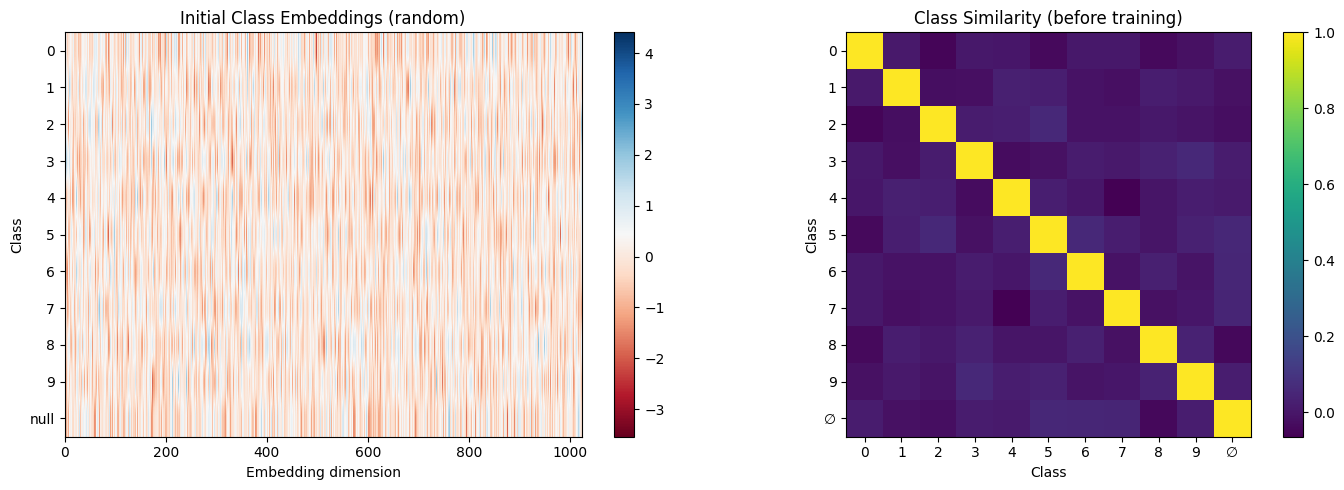


📊 Key Insight:
   Before training, all classes have random, uncorrelated embeddings.
   After training, similar digits (like 3 and 8) might become more similar!


In [2]:
from from_noise_to_images.dit import ClassEmbedding

# Create a class embedding layer
num_classes = 10
embed_dim = 1024  # Same as cond_dim in our model
class_embed = ClassEmbedding(num_classes, embed_dim)

print(f"Embedding table shape: {class_embed.embed.weight.shape}")
print(f"  - {num_classes + 1} classes (10 digits + 1 null class)")
print(f"  - {embed_dim} dimensions per class")

# Visualize the initial embeddings
with torch.no_grad():
    all_embeddings = class_embed.embed.weight.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Show the embedding matrix
im = axes[0].imshow(all_embeddings, aspect='auto', cmap='RdBu')
axes[0].set_xlabel('Embedding dimension')
axes[0].set_ylabel('Class')
axes[0].set_yticks(range(11))
axes[0].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[0].set_title('Initial Class Embeddings (random)')
plt.colorbar(im, ax=axes[0])

# Show similarity matrix
similarity = np.corrcoef(all_embeddings)
im = axes[1].imshow(similarity, cmap='viridis')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Class')
axes[1].set_xticks(range(11))
axes[1].set_xticklabels([str(i) for i in range(10)] + ['∅'])
axes[1].set_yticks(range(11))
axes[1].set_yticklabels([str(i) for i in range(10)] + ['∅'])
axes[1].set_title('Class Similarity (before training)')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n📊 Key Insight:")
print("   Before training, all classes have random, uncorrelated embeddings.")
print("   After training, similar digits (like 3 and 8) might become more similar!")

## 2. Conditioning the DiT: Combining Time and Class

In Phase 2, our DiT was conditioned only on timestep $t$. Now we add class conditioning. The question: how do we combine these two pieces of information?

### Mathematical Framework

We have two conditioning signals:
- **Timestep**: $t \in [0, 1]$ → embedded as $h_t = \text{TimeEmbed}(t) \in \mathbb{R}^D$
- **Class**: $y \in \{0, \ldots, 9\}$ → embedded as $h_y = e(y) \in \mathbb{R}^D$

We need to combine these into a single conditioning vector $c \in \mathbb{R}^D$.

### Addition: The Simplest Approach

We use **element-wise addition**:

$$c = h_t + h_y = \text{TimeEmbed}(t) + e(y)$$

This is mathematically elegant because:

1. **Superposition**: The network can learn to disentangle the two signals
2. **Shared representation space**: Both embeddings live in the same $\mathbb{R}^D$
3. **Computational efficiency**: No additional parameters or operations

### Why Addition Works: A Linear Algebra Perspective

Consider the combined conditioning as occupying different "subspaces":

$$c = h_t + h_y \approx P_t h + P_y h$$

where $P_t$ and $P_y$ are (implicit) projection matrices. If the model learns orthogonal or near-orthogonal representations for time and class, it can cleanly separate them:

$$\text{Time information: } \langle c, u_t \rangle \approx \langle h_t, u_t \rangle$$
$$\text{Class information: } \langle c, u_y \rangle \approx \langle h_y, u_y \rangle$$

for learned direction vectors $u_t$ and $u_y$.

### Integration with adaLN

The combined conditioning $c$ feeds into adaLN (from Phase 2):

$$\text{adaLN}(x, c) = \gamma(c) \odot \frac{x - \mu}{\sigma} + \beta(c)$$

where $\gamma(c) = W_\gamma c + b_\gamma$ and $\beta(c) = W_\beta c + b_\beta$ are linear projections.

Expanding with our combined conditioning:

$$\gamma(c) = \gamma(h_t + h_y) = W_\gamma h_t + W_\gamma h_y + b_\gamma$$

The network learns to use both time and class information through these modulation parameters.

### Architecture Comparison

```
Phase 2 (Unconditional)          Phase 3 (Class-Conditional)
                                 
   Timestep t                       Timestep t    Class y
      │                                │            │
      ▼                                ▼            ▼
  TimeEmbed                        TimeEmbed    ClassEmbed
      │                                │            │
      ▼                                └─────┬──────┘
   h_t ∈ ℝᴰ                                 +
      │                                      │
      ▼                                      ▼
   adaLN                                c ∈ ℝᴰ
      │                                      │
      ▼                                      ▼
   DiT Blocks                             adaLN
                                             │
                                             ▼
                                         DiT Blocks
```

Conditioning Vector Construction:
   Time embedding:   torch.Size([1, 1024]) → represents t=0.3
   Class embedding:  torch.Size([1, 1024]) → represents digit 7
   Combined:         torch.Size([1, 1024]) → used for adaLN conditioning


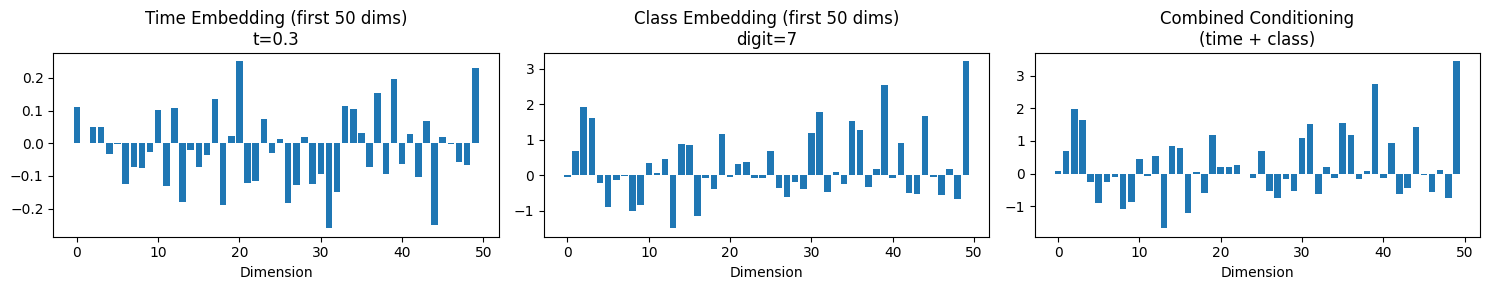

In [3]:
from from_noise_to_images.dit import TimestepEmbedding, ClassEmbedding

# Create embedding modules
embed_dim = 256
cond_dim = embed_dim * 4  # 1024

time_embed = TimestepEmbedding(embed_dim, cond_dim)
class_embed = ClassEmbedding(10, cond_dim)

# Sample inputs
t = torch.tensor([0.3])  # Timestep
y = torch.tensor([7])    # Class label (digit 7)

with torch.no_grad():
    time_cond = time_embed(t)
    class_cond = class_embed(y)
    combined = time_cond + class_cond

print("Conditioning Vector Construction:")
print(f"   Time embedding:   {time_cond.shape} → represents t={t.item():.1f}")
print(f"   Class embedding:  {class_cond.shape} → represents digit {y.item()}")
print(f"   Combined:         {combined.shape} → used for adaLN conditioning")

# Visualize the combination
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

axes[0].bar(range(50), time_cond[0, :50].numpy())
axes[0].set_title(f'Time Embedding (first 50 dims)\nt={t.item():.1f}')
axes[0].set_xlabel('Dimension')

axes[1].bar(range(50), class_cond[0, :50].numpy())
axes[1].set_title(f'Class Embedding (first 50 dims)\ndigit={y.item()}')
axes[1].set_xlabel('Dimension')

axes[2].bar(range(50), combined[0, :50].numpy())
axes[2].set_title('Combined Conditioning\n(time + class)')
axes[2].set_xlabel('Dimension')

plt.tight_layout()
plt.show()

## 3. Classifier-Free Guidance: The Mathematical Foundation

Here's a problem: training with class labels and sampling with class labels often produces "weak" conditioning. The model generates vaguely correct digits, but they don't really "pop".

**Classifier-Free Guidance (CFG)** solves this. It's arguably the most important technique in modern conditional generation.

### The Score Function Perspective

To understand CFG, let's think in terms of **score functions** (gradients of log-probability):

$$s_\theta(x_t, t, y) = \nabla_{x_t} \log p_\theta(x_t \mid t, y)$$

In diffusion/flow models, the velocity field relates to the score:

$$v_\theta(x_t, t, y) \propto -\sigma_t \cdot s_\theta(x_t, t, y)$$

### Applying Bayes' Theorem

Using Bayes' rule for the conditional distribution:

$$\log p(x \mid y) = \log p(y \mid x) + \log p(x) - \log p(y)$$

Taking gradients with respect to $x$:

$$\nabla_x \log p(x \mid y) = \nabla_x \log p(y \mid x) + \nabla_x \log p(x)$$

or equivalently:

$$s(x \mid y) = s(x \mid y) - s(x) + s(x) = \underbrace{s(x)}_{\text{unconditional}} + \underbrace{(s(x \mid y) - s(x))}_{\text{classifier gradient}}$$

### The CFG Insight: Amplifying the Classifier Gradient

CFG amplifies the "classifier gradient" term:

$$s_{\text{CFG}}(x, y, w) = s(x) + w \cdot (s(x \mid y) - s(x))$$

where $w > 1$ is the **guidance scale**. Simplifying:

$$s_{\text{CFG}}(x, y, w) = (1 - w) \cdot s(x) + w \cdot s(x \mid y)$$

### CFG Formula for Velocity Fields

Translating to velocity fields:

$$\boxed{v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})}$$

which can also be written as:

$$v_{\text{CFG}} = (1 - w) \cdot v_{\text{uncond}} + w \cdot v_{\text{cond}}$$

Where:
- $v_{\text{cond}} = v_\theta(x_t, t, y)$: Velocity with class label
- $v_{\text{uncond}} = v_\theta(x_t, t, \emptyset)$: Velocity with null class
- $w$: Guidance scale (typically 3-7)

### Intuitive Understanding

| Term | Meaning |
|------|---------|
| $v_{\text{uncond}}$ | "What does any digit look like at this noise level?" |
| $v_{\text{cond}}$ | "What does digit $y$ look like at this noise level?" |
| $v_{\text{cond}} - v_{\text{uncond}}$ | "What makes this specifically digit $y$?" |
| $w \cdot (\ldots)$ | "Amplify the $y$-specific features" |

### Effect of Guidance Scale

| Scale $w$ | Effect | Mathematical View |
|-----------|--------|-------------------|
| $w = 0$ | Pure unconditional | $v_{\text{CFG}} = v_{\text{uncond}}$ |
| $w = 1$ | Pure conditional (no guidance) | $v_{\text{CFG}} = v_{\text{cond}}$ |
| $w = 3\text{-}5$ | Good balance | Amplified conditioning |
| $w > 7$ | Over-saturation | Too much class signal, artifacts |

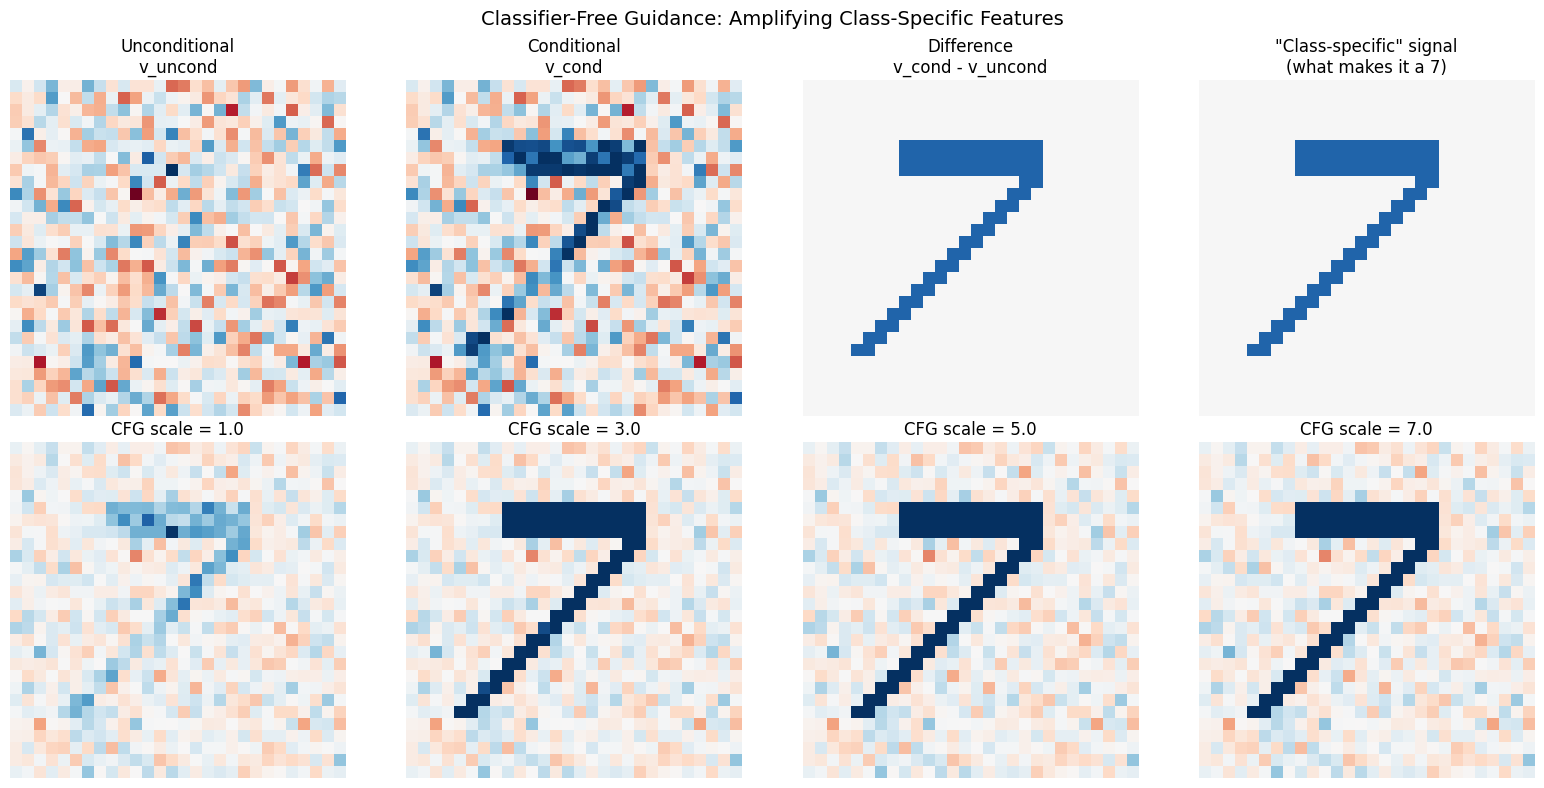


📊 CFG Formula: v_guided = v_uncond + scale × (v_cond - v_uncond)

   • scale=1: Pure conditional (no amplification)
   • scale>1: Amplifies what the class 'adds' to the prediction
   • Higher scale = stronger adherence to class, but may reduce quality


In [4]:
def visualize_cfg_concept():
    """
    Visualize how CFG amplifies the conditional signal.
    """
    # Create synthetic "velocities" to illustrate the concept
    np.random.seed(42)
    
    # Unconditional: generic velocity field
    v_uncond = np.random.randn(28, 28) * 0.3
    
    # Conditional: adds class-specific structure (e.g., "7" shape)
    v_class_specific = np.zeros((28, 28))
    # Horizontal bar at top (the top of a 7)
    v_class_specific[5:8, 8:20] = 0.8
    # Diagonal stroke
    for i in range(15):
        v_class_specific[8+i, 18-i:20-i] = 0.8
    
    v_cond = v_uncond + v_class_specific
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: The components
    im = axes[0, 0].imshow(v_uncond, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 0].set_title('Unconditional\nv_uncond', fontsize=12)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(v_cond, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 1].set_title('Conditional\nv_cond', fontsize=12)
    axes[0, 1].axis('off')
    
    difference = v_cond - v_uncond
    axes[0, 2].imshow(difference, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 2].set_title('Difference\nv_cond - v_uncond', fontsize=12)
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(v_class_specific, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 3].set_title('"Class-specific" signal\n(what makes it a 7)', fontsize=12)
    axes[0, 3].axis('off')
    
    # Row 2: Different CFG scales
    scales = [1.0, 3.0, 5.0, 7.0]
    
    for i, scale in enumerate(scales):
        v_guided = v_uncond + scale * difference
        axes[1, i].imshow(v_guided, cmap='RdBu', vmin=-2, vmax=2)
        axes[1, i].set_title(f'CFG scale = {scale}', fontsize=12)
        axes[1, i].axis('off')
    
    plt.suptitle('Classifier-Free Guidance: Amplifying Class-Specific Features', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 CFG Formula: v_guided = v_uncond + scale × (v_cond - v_uncond)")
    print("\n   • scale=1: Pure conditional (no amplification)")
    print("   • scale>1: Amplifies what the class 'adds' to the prediction")
    print("   • Higher scale = stronger adherence to class, but may reduce quality")

visualize_cfg_concept()

## 4. Label Dropout: Training for Classifier-Free Guidance

For CFG to work at inference, we need to run the model **twice**: once conditional ($v_{\text{cond}}$) and once unconditional ($v_{\text{uncond}}$). But how does a single model learn both behaviors?

### The Solution: Probabilistic Label Dropout

During training, we **randomly drop the class label** with probability $p_{\text{drop}}$:

$$y_{\text{train}} = \begin{cases}
y & \text{with probability } 1 - p_{\text{drop}} \\
\emptyset & \text{with probability } p_{\text{drop}}
\end{cases}$$

Typically $p_{\text{drop}} = 0.1$ (10%).

### Mathematical Interpretation

The training objective becomes a **mixture** of conditional and unconditional losses:

$$\mathcal{L}_{\text{CFG}} = (1 - p_{\text{drop}}) \cdot \mathbb{E}[\|v_\theta(x_t, t, y) - v_{\text{target}}\|^2] + p_{\text{drop}} \cdot \mathbb{E}[\|v_\theta(x_t, t, \emptyset) - v_{\text{target}}\|^2]$$

Or equivalently:

$$\mathcal{L}_{\text{CFG}} = \mathbb{E}_{y_{\text{train}}}[\|v_\theta(x_t, t, y_{\text{train}}) - v_{\text{target}}\|^2]$$

where $y_{\text{train}}$ is sampled according to the dropout distribution.

### What the Model Learns

| Training Mode | Fraction | The Model Learns |
|---------------|----------|------------------|
| Conditional | 90% | $v_\theta(x_t, t, y) \approx \mathbb{E}[v \mid x_t, t, y]$ |
| Unconditional | 10% | $v_\theta(x_t, t, \emptyset) \approx \mathbb{E}[v \mid x_t, t]$ |

The **same model** learns both the conditional and marginal velocity fields!

### The Null Embedding

When the label is dropped, we use a learned **null embedding** $e_\emptyset$:

$$c_{\text{uncond}} = h_t + e_\emptyset$$

rather than simply zeroing out the class signal. This allows the model to learn a proper representation for "no class specified".

### Why 10% Dropout?

The choice of $p_{\text{drop}} = 0.1$ balances two considerations:

1. **Too low** (e.g., 1%): Model rarely sees unconditional examples → poor $v_{\text{uncond}}$ estimates
2. **Too high** (e.g., 50%): Model sees fewer conditional examples → weaker $v_{\text{cond}}$

10% is empirically found to work well across most applications.

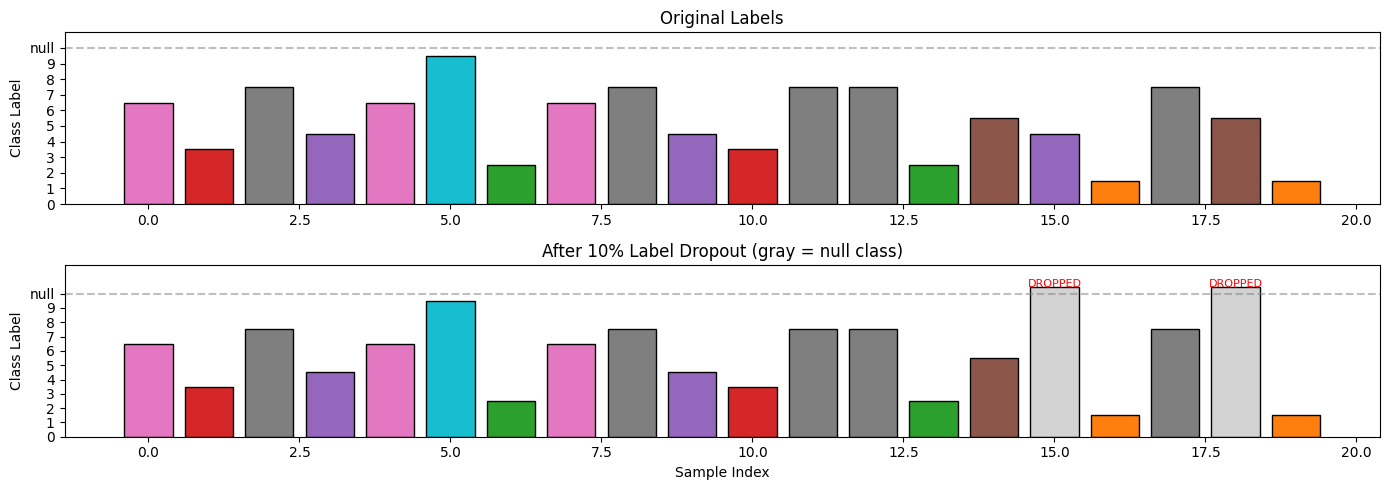


📊 Label Dropout Statistics:
   • Total samples: 20
   • Dropped: 2 (10%)
   • Kept: 18 (90%)


In [5]:
def visualize_label_dropout():
    """
    Show how label dropout works during training.
    """
    np.random.seed(42)
    batch_size = 20
    drop_prob = 0.1
    
    # Simulate original labels
    original_labels = np.random.randint(0, 10, batch_size)
    
    # Simulate dropout
    drop_mask = np.random.rand(batch_size) < drop_prob
    labels_after_dropout = original_labels.copy()
    labels_after_dropout[drop_mask] = 10  # Null class
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 5))
    
    # Original labels
    colors = plt.cm.tab10(original_labels / 10)
    bars = axes[0].bar(range(batch_size), original_labels + 0.5, color=colors, edgecolor='black')
    axes[0].set_ylabel('Class Label')
    axes[0].set_title('Original Labels', fontsize=12)
    axes[0].set_ylim(0, 11)
    axes[0].set_yticks(range(11))
    axes[0].set_yticklabels([str(i) for i in range(10)] + ['null'])
    axes[0].axhline(y=10, color='gray', linestyle='--', alpha=0.5)
    
    # After dropout
    colors_after = []
    for i, (orig, after) in enumerate(zip(original_labels, labels_after_dropout)):
        if after == 10:  # Dropped
            colors_after.append('lightgray')
        else:
            colors_after.append(plt.cm.tab10(orig / 10))
    
    bars = axes[1].bar(range(batch_size), labels_after_dropout + 0.5, color=colors_after, edgecolor='black')
    # Highlight dropped samples
    for i, dropped in enumerate(drop_mask):
        if dropped:
            axes[1].annotate('DROPPED', (i, 10.5), ha='center', fontsize=8, color='red')
    
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Class Label')
    axes[1].set_title(f'After {drop_prob*100:.0f}% Label Dropout (gray = null class)', fontsize=12)
    axes[1].set_ylim(0, 12)
    axes[1].set_yticks(range(11))
    axes[1].set_yticklabels([str(i) for i in range(10)] + ['null'])
    axes[1].axhline(y=10, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Label Dropout Statistics:")
    print(f"   • Total samples: {batch_size}")
    print(f"   • Dropped: {drop_mask.sum()} ({drop_mask.mean()*100:.0f}%)")
    print(f"   • Kept: {(~drop_mask).sum()} ({(~drop_mask).mean()*100:.0f}%)")

visualize_label_dropout()

## 5. The Conditional DiT Architecture

Let's examine our class-conditional DiT. The changes from Phase 2 are minimal but powerful.

### Forward Pass Comparison

**Phase 2 (Unconditional):**
$$v_\theta(x, t) = \text{DiT}(x, \text{TimeEmbed}(t))$$

**Phase 3 (Conditional):**
$$v_\theta(x, t, y) = \text{ConditionalDiT}(x, \text{TimeEmbed}(t) + e(y))$$

### Mathematical Summary

| Component | Equation | Shape |
|-----------|----------|-------|
| Time embedding | $h_t = \text{TimeEmbed}(t)$ | $\mathbb{R}^D$ |
| Class embedding | $h_y = e(y) = W_e[y]$ | $\mathbb{R}^D$ |
| Combined conditioning | $c = h_t + h_y$ | $\mathbb{R}^D$ |
| adaLN modulation | $\gamma, \beta = \text{Linear}(c)$ | $\mathbb{R}^{d_{model}}$ each |

### Parameter Count

The only additional parameters are the class embeddings:

$$\Delta_{\text{params}} = (K + 1) \times D = 11 \times 1024 = 11{,}264$$

where:
- $K = 10$ digit classes
- $+1$ for the null class
- $D = 1024$ embedding dimension

In [6]:
from from_noise_to_images.dit import ConditionalDiT

# Create the conditional DiT model
model = ConditionalDiT(
    num_classes=10,     # 10 digit classes
    img_size=28,        # MNIST image size
    patch_size=4,       # 4×4 patches → 7×7 = 49 patches
    in_channels=1,      # Grayscale
    embed_dim=256,      # Embedding dimension
    depth=6,            # Number of transformer blocks
    num_heads=8,        # Attention heads
    mlp_ratio=4.0,      # MLP expansion
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"ConditionalDiT Parameters: {num_params:,}")

# Compare to unconditional DiT
from from_noise_to_images.dit import DiT
uncond_model = DiT()
uncond_params = sum(p.numel() for p in uncond_model.parameters() if p.requires_grad)
print(f"Unconditional DiT Parameters: {uncond_params:,}")
print(f"Difference: {num_params - uncond_params:,} (the class embeddings)")

# Test forward pass with different inputs
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)
test_y = torch.randint(0, 10, (4,), device=device)

print("\n--- Testing Forward Pass ---")

# With class labels
with torch.no_grad():
    out_cond = model(test_x, test_t, test_y)
print(f"With class labels:    input {test_x.shape} → output {out_cond.shape}")

# Without class labels (unconditional)
with torch.no_grad():
    out_uncond = model(test_x, test_t, y=None)
print(f"Without class labels: input {test_x.shape} → output {out_uncond.shape}")

print("\n✓ Model handles both conditional and unconditional forward passes!")

ConditionalDiT Parameters: 12,363,024
Unconditional DiT Parameters: 12,351,760
Difference: 11,264 (the class embeddings)

--- Testing Forward Pass ---
With class labels:    input torch.Size([4, 1, 28, 28]) → output torch.Size([4, 1, 28, 28])
Without class labels: input torch.Size([4, 1, 28, 28]) → output torch.Size([4, 1, 28, 28])

✓ Model handles both conditional and unconditional forward passes!


## 6. Training the Conditional DiT

The training loop is nearly identical to Phase 2, with two modifications:

### Conditional Loss Function

For each training sample $(x_0, y)$ where $x_0$ is an image and $y$ is its class:

1. **Sample noise and time**: $x_1 \sim \mathcal{N}(0, I)$, $t \sim \text{Uniform}(0, 1)$
2. **Interpolate**: $x_t = (1-t) x_0 + t x_1$
3. **Apply label dropout**:
$$y_{\text{train}} = \begin{cases} y & \text{w.p. } 0.9 \\ \emptyset & \text{w.p. } 0.1 \end{cases}$$
4. **Compute loss**: $\mathcal{L} = \| v_\theta(x_t, t, y_{\text{train}}) - (x_1 - x_0) \|^2$

### Algorithm: Conditional Flow Matching Training

```
Input: Dataset {(x, y)}, model v_θ, dropout probability p_drop
For each batch:
    1. Sample (x₀, y) from dataset
    2. Sample x₁ ~ N(0, I), t ~ U(0, 1)
    3. Compute x_t = (1-t)·x₀ + t·x₁
    4. Compute target v = x₁ - x₀
    5. With probability p_drop: y ← ∅ (null class)
    6. Predict v̂ = v_θ(x_t, t, y)
    7. Loss = ||v̂ - v||²
    8. Backpropagate and update θ
```

The `ConditionalTrainer` class implements this with the label dropout handled automatically.

In [7]:
# Load MNIST with labels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

# Show sample data
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels: {labels[:10].tolist()}...")

Batch shape: torch.Size([128, 1, 28, 28])
Labels: [0, 0, 1, 0, 7, 6, 8, 7, 0, 1]...


In [8]:
from from_noise_to_images.train import ConditionalTrainer

# Create the conditional trainer
trainer = ConditionalTrainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    label_drop_prob=0.1,  # 10% label dropout for CFG
    num_classes=10,
    device=device,
)

print("Training Conditional DiT with CFG label dropout...")
print("(10% of samples trained without class labels)\n")

NUM_EPOCHS = 30  # Increase for better results
losses = trainer.train(num_epochs=NUM_EPOCHS)

Training Conditional DiT with CFG label dropout...
(10% of samples trained without class labels)

Training on cuda
Model parameters: 12,363,024
CFG label dropout: 10%


Epoch 1/30: 100%|████████████████| 468/468 [00:20<00:00, 23.02it/s, loss=0.3772]


Epoch 1: avg_loss = 0.8324


Epoch 2/30: 100%|████████████████| 468/468 [00:20<00:00, 23.26it/s, loss=0.2918]


Epoch 2: avg_loss = 0.3338


Epoch 3/30: 100%|████████████████| 468/468 [00:20<00:00, 23.25it/s, loss=0.2891]


Epoch 3: avg_loss = 0.2963


Epoch 4/30: 100%|████████████████| 468/468 [00:20<00:00, 23.23it/s, loss=0.2774]


Epoch 4: avg_loss = 0.2828


Epoch 5/30: 100%|████████████████| 468/468 [00:20<00:00, 23.24it/s, loss=0.2827]


Epoch 5: avg_loss = 0.2723


Epoch 6/30: 100%|████████████████| 468/468 [00:20<00:00, 23.17it/s, loss=0.2635]


Epoch 6: avg_loss = 0.2635


Epoch 7/30: 100%|████████████████| 468/468 [00:20<00:00, 23.24it/s, loss=0.2379]


Epoch 7: avg_loss = 0.2558


Epoch 8/30: 100%|████████████████| 468/468 [00:20<00:00, 23.19it/s, loss=0.2423]


Epoch 8: avg_loss = 0.2474


Epoch 9/30: 100%|████████████████| 468/468 [00:20<00:00, 23.14it/s, loss=0.2393]


Epoch 9: avg_loss = 0.2349


Epoch 10/30: 100%|███████████████| 468/468 [00:20<00:00, 23.14it/s, loss=0.2163]


Epoch 10: avg_loss = 0.2213


Epoch 11/30: 100%|███████████████| 468/468 [00:20<00:00, 23.07it/s, loss=0.2203]


Epoch 11: avg_loss = 0.2116


Epoch 12/30: 100%|███████████████| 468/468 [00:20<00:00, 23.09it/s, loss=0.1978]


Epoch 12: avg_loss = 0.2065


Epoch 13/30: 100%|███████████████| 468/468 [00:20<00:00, 23.15it/s, loss=0.1999]


Epoch 13: avg_loss = 0.2023


Epoch 14/30: 100%|███████████████| 468/468 [00:20<00:00, 23.09it/s, loss=0.2003]


Epoch 14: avg_loss = 0.1987


Epoch 15/30: 100%|███████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.2086]


Epoch 15: avg_loss = 0.1959


Epoch 16/30: 100%|███████████████| 468/468 [00:20<00:00, 22.97it/s, loss=0.1967]


Epoch 16: avg_loss = 0.1933


Epoch 17/30: 100%|███████████████| 468/468 [00:20<00:00, 22.99it/s, loss=0.1843]


Epoch 17: avg_loss = 0.1917


Epoch 18/30: 100%|███████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.1732]


Epoch 18: avg_loss = 0.1893


Epoch 19/30: 100%|███████████████| 468/468 [00:20<00:00, 23.00it/s, loss=0.1762]


Epoch 19: avg_loss = 0.1878


Epoch 20/30: 100%|███████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.1872]


Epoch 20: avg_loss = 0.1865


Epoch 21/30: 100%|███████████████| 468/468 [00:20<00:00, 23.06it/s, loss=0.1788]


Epoch 21: avg_loss = 0.1854


Epoch 22/30: 100%|███████████████| 468/468 [00:20<00:00, 23.04it/s, loss=0.1966]


Epoch 22: avg_loss = 0.1844


Epoch 23/30: 100%|███████████████| 468/468 [00:20<00:00, 23.06it/s, loss=0.1806]


Epoch 23: avg_loss = 0.1827


Epoch 24/30: 100%|███████████████| 468/468 [00:20<00:00, 23.00it/s, loss=0.1801]


Epoch 24: avg_loss = 0.1825


Epoch 25/30: 100%|███████████████| 468/468 [00:20<00:00, 23.04it/s, loss=0.1643]


Epoch 25: avg_loss = 0.1812


Epoch 26/30: 100%|███████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.1843]


Epoch 26: avg_loss = 0.1799


Epoch 27/30: 100%|███████████████| 468/468 [00:20<00:00, 23.04it/s, loss=0.1818]


Epoch 27: avg_loss = 0.1789


Epoch 28/30: 100%|███████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.1741]


Epoch 28: avg_loss = 0.1793


Epoch 29/30: 100%|███████████████| 468/468 [00:20<00:00, 23.00it/s, loss=0.1895]


Epoch 29: avg_loss = 0.1782


Epoch 30/30: 100%|███████████████| 468/468 [00:20<00:00, 23.02it/s, loss=0.1752]

Epoch 30: avg_loss = 0.1773


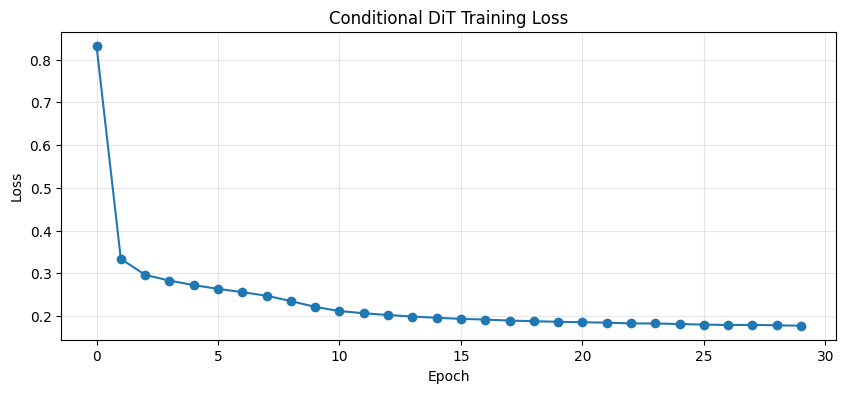


Final loss: 0.1773


In [9]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Conditional DiT Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal loss: {losses[-1]:.4f}")

## 7. Sampling with Classifier-Free Guidance

Now for the exciting part - generating specific digits with controllable guidance!

### CFG Sampling Algorithm

At each step of the ODE solver, we apply CFG:

**Algorithm: CFG-Guided Euler Sampling**

```
Input: Trained model v_θ, target class y, guidance scale w, num_steps N
x_t ← sample from N(0, I)    # Start with pure noise
dt = 1/N                      # Step size

For t = 1, 1-dt, 1-2dt, ..., dt:
    # Get conditional velocity (with class)
    v_cond = v_θ(x_t, t, y)
    
    # Get unconditional velocity (with null class ∅)
    v_uncond = v_θ(x_t, t, ∅)
    
    # Apply CFG formula
    v_guided = v_uncond + w · (v_cond - v_uncond)
    
    # Euler step (backward in time)
    x_t ← x_t - dt · v_guided

Return x_0    # Generated image
```

### Computational Cost

CFG requires **two forward passes** per sampling step:

| Method | Forward Passes per Step | Total for 50 Steps |
|--------|------------------------|-------------------|
| Unconditional | 1 | 50 |
| Conditional (no CFG) | 1 | 50 |
| Conditional + CFG | 2 | 100 |

This 2× cost is why CFG is sometimes called "expensive" - but the quality improvement is worth it.

### Implementation Note

In practice, we can batch the two forward passes together for efficiency:

```python
# Efficient: batch conditional and unconditional together
x_batch = torch.cat([x_t, x_t])           # [2B, C, H, W]
y_batch = torch.cat([y, null_class])       # [2B]
v_batch = model(x_batch, t, y_batch)       # Single forward pass
v_cond, v_uncond = v_batch.chunk(2)        # Split results
```

Generating 4 samples for each digit (0-9) with CFG scale=4.0...


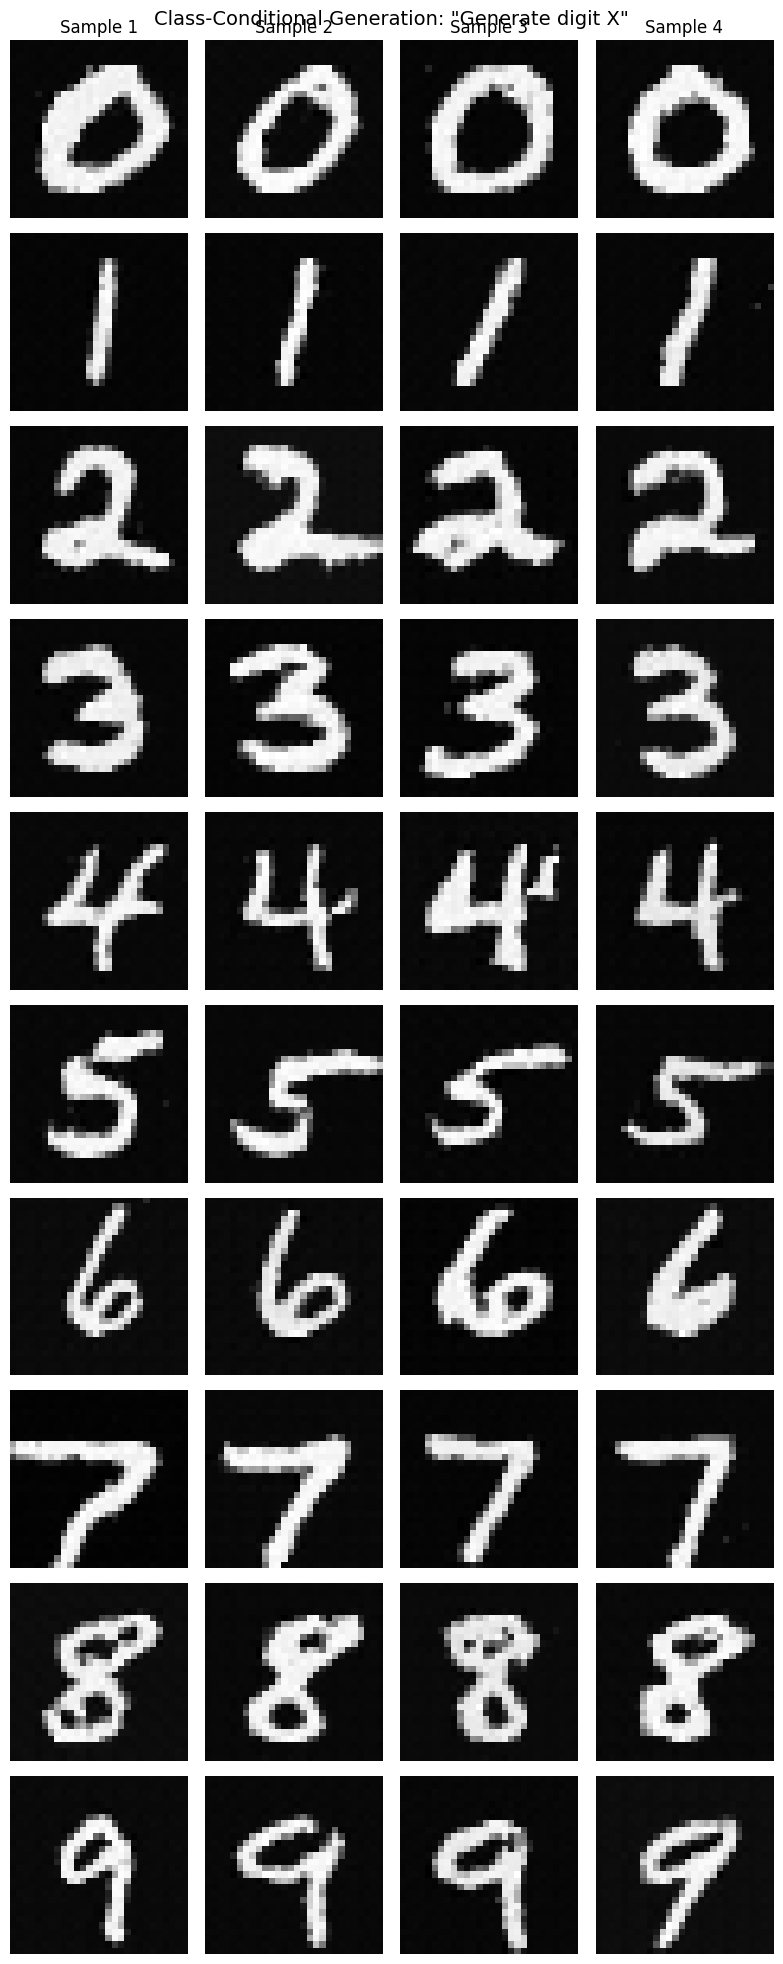

In [10]:
from from_noise_to_images.sampling import sample_conditional, sample_each_class

def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    images = (images + 1) / 2  # Denormalize
    images = images.clamp(0, 1)
    
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

# Generate samples for each class
model.eval()

print("Generating 4 samples for each digit (0-9) with CFG scale=4.0...")

samples = sample_each_class(
    model=model,
    num_per_class=4,
    image_shape=(1, 28, 28),
    num_steps=50,
    cfg_scale=4.0,
    device=device,
)

# Reshape for display: (40, 1, 28, 28) → (10, 4, 1, 28, 28)
samples_grid = samples.view(10, 4, 1, 28, 28)

# Create a nice display
fig, axes = plt.subplots(10, 4, figsize=(8, 20))

for digit in range(10):
    for i in range(4):
        img = (samples_grid[digit, i, 0] + 1) / 2
        axes[digit, i].imshow(img.cpu().numpy(), cmap='gray')
        axes[digit, i].axis('off')
        if i == 0:
            axes[digit, i].set_ylabel(f'{digit}', rotation=0, fontsize=14, labelpad=20)
        if digit == 0:
            axes[digit, i].set_title(f'Sample {i+1}')

plt.suptitle('Class-Conditional Generation: "Generate digit X"', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Effect of Guidance Scale

The guidance scale $w$ controls the **trade-off between sample quality and diversity**:

### Mathematical Interpretation

Recall the CFG formula:

$$v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})$$

- **Low $w$**: Samples closer to the learned distribution → more diversity, less class fidelity
- **High $w$**: Samples pushed toward class-specific regions → less diversity, higher class fidelity

### Quality-Diversity Trade-off

This is formalized as:

$$\text{High } w \implies \text{Low } H(x \mid y) \implies \text{Strong conditioning}$$

where $H(x \mid y)$ is the conditional entropy of generated samples given class $y$.

Let's visualize this trade-off:

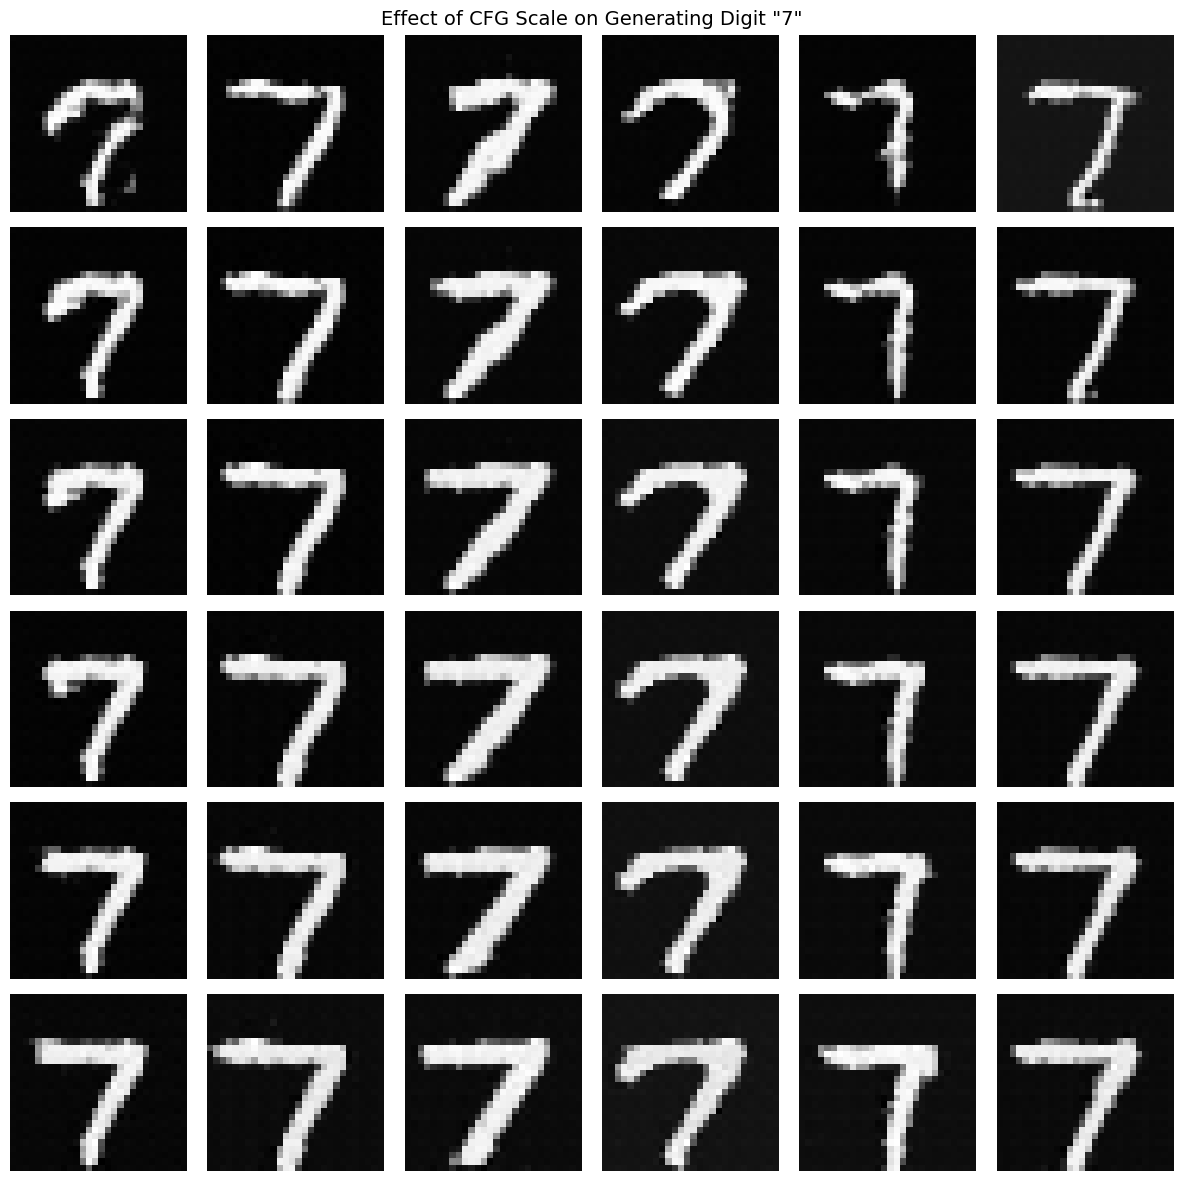


📊 CFG Scale Analysis:
   • scale=1.0: No guidance (pure conditional)
   • scale=2-3: Light guidance, maintains diversity
   • scale=4-5: Strong guidance, clear digit identity
   • scale=7+: Very strong, may oversaturate/distort


In [11]:
def compare_cfg_scales(model, target_digit=7, scales=[1.0, 2.0, 3.0, 4.0, 5.0, 7.0]):
    """
    Compare generation quality across different CFG scales.
    """
    num_samples = 6
    
    # Use same random seed for fair comparison
    torch.manual_seed(42)
    initial_noise = torch.randn(num_samples, 1, 28, 28, device=device)
    
    fig, axes = plt.subplots(len(scales), num_samples, figsize=(12, 2*len(scales)))
    
    for row, scale in enumerate(scales):
        # Reset to same noise
        torch.manual_seed(42)
        
        labels = torch.full((num_samples,), target_digit, dtype=torch.long)
        samples = sample_conditional(
            model=model,
            class_labels=labels,
            image_shape=(1, 28, 28),
            num_steps=50,
            cfg_scale=scale,
            device=device,
        )
        
        for col in range(num_samples):
            img = (samples[col, 0] + 1) / 2
            axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_ylabel(f'scale={scale}', fontsize=11)
    
    plt.suptitle(f'Effect of CFG Scale on Generating Digit "{target_digit}"', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 CFG Scale Analysis:")
    print("   • scale=1.0: No guidance (pure conditional)")
    print("   • scale=2-3: Light guidance, maintains diversity")
    print("   • scale=4-5: Strong guidance, clear digit identity")
    print("   • scale=7+: Very strong, may oversaturate/distort")

compare_cfg_scales(model, target_digit=7)

Generating 8 samples for each digit with CFG scale=4.0...



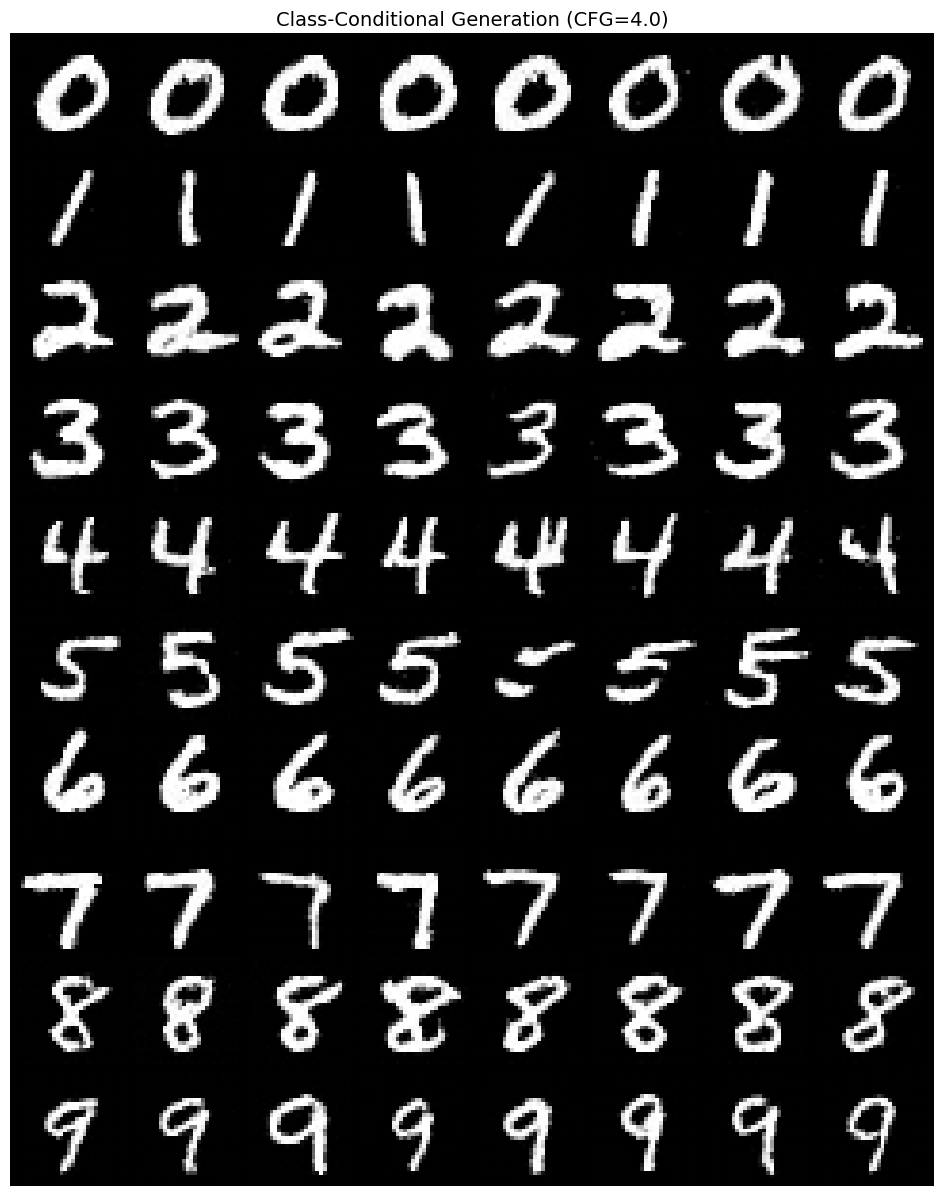

Each row is a different digit class (0-9)
Each column is a different sample from that class


In [12]:
# Compare generation for different digits at optimal CFG scale
print("Generating 8 samples for each digit with CFG scale=4.0...\n")

samples_all = sample_each_class(
    model=model,
    num_per_class=8,
    image_shape=(1, 28, 28),
    num_steps=50,
    cfg_scale=4.0,
    device=device,
)

# Show as 10 rows (one per digit), 8 columns (samples)
show_images(samples_all, nrow=8, title='Class-Conditional Generation (CFG=4.0)')

print("Each row is a different digit class (0-9)")
print("Each column is a different sample from that class")

## 9. Conditional vs Unconditional Comparison

Let's directly compare three sampling modes for the same target class:

| Mode | Class Input | CFG Scale | Distribution Sampled |
|------|-------------|-----------|---------------------|
| Unconditional | $\emptyset$ | N/A | $p(x)$ |
| Conditional (no CFG) | $y$ | $w=1$ | $p(x \mid y)$ |
| Conditional + CFG | $y$ | $w>1$ | "Sharpened" $p(x \mid y)$ |

The CFG-guided samples should show the strongest class identity.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06109935..1.073801].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037380517..1.0571901].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.078953326..1.1051254].


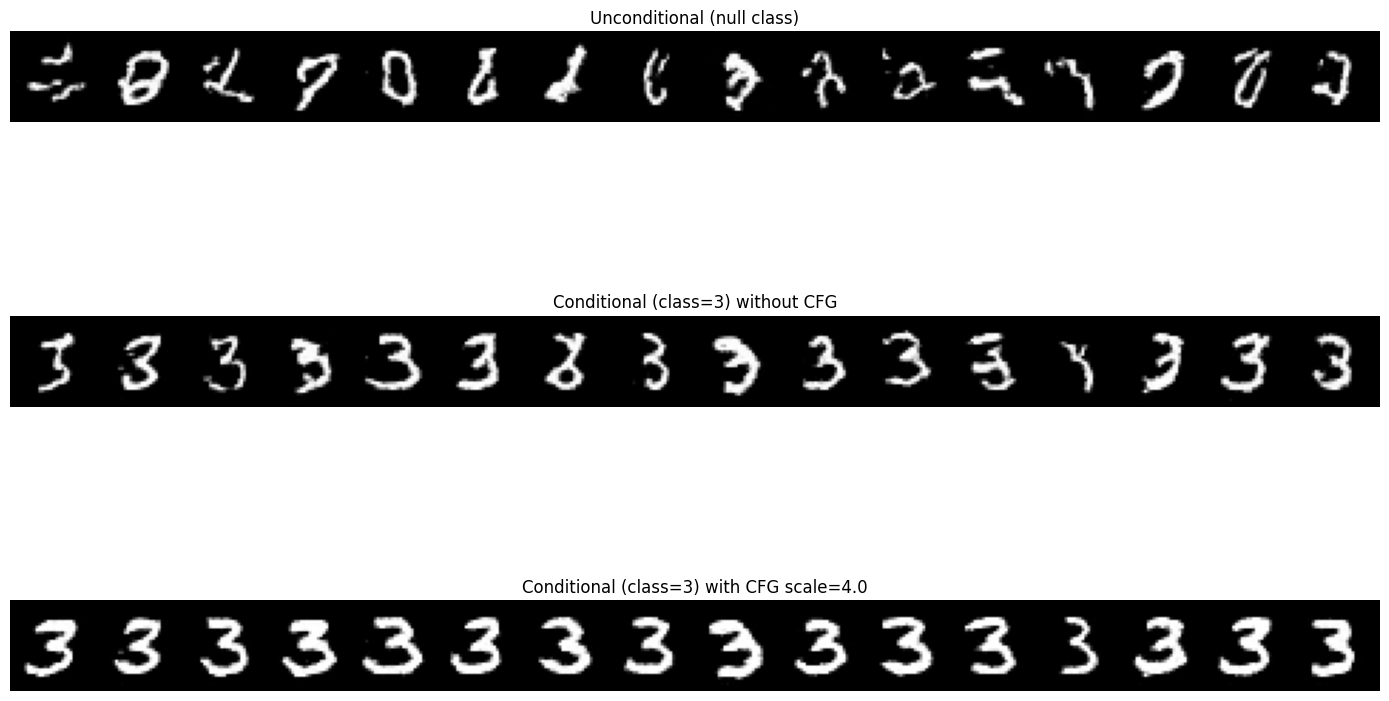


📊 Comparison for generating '3':
   • Unconditional: Random digits (no control)
   • Conditional (no CFG): Tends toward 3 but may be weak
   • Conditional (CFG=4): Strong 3 identity


In [13]:
from from_noise_to_images.sampling import sample

# Set seed for reproducibility
torch.manual_seed(123)

target_class = 3  # Generate threes
num_samples = 16

# 1. Unconditional (no class)
# Use null class for all samples
null_labels = torch.full((num_samples,), 10, dtype=torch.long, device=device)  # 10 = null
uncond_samples = sample_conditional(
    model=model,
    class_labels=null_labels,
    image_shape=(1, 28, 28),
    cfg_scale=1.0,  # No guidance
    device=device,
)

# 2. Conditional without CFG
torch.manual_seed(123)
cond_nocfg_samples = sample_conditional(
    model=model,
    class_labels=[target_class] * num_samples,
    image_shape=(1, 28, 28),
    cfg_scale=1.0,  # No amplification
    device=device,
)

# 3. Conditional with CFG
torch.manual_seed(123)
cond_cfg_samples = sample_conditional(
    model=model,
    class_labels=[target_class] * num_samples,
    image_shape=(1, 28, 28),
    cfg_scale=4.0,  # Strong guidance
    device=device,
)

# Display comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for ax, samples, title in [
    (axes[0], uncond_samples, 'Unconditional (null class)'),
    (axes[1], cond_nocfg_samples, f'Conditional (class={target_class}) without CFG'),
    (axes[2], cond_cfg_samples, f'Conditional (class={target_class}) with CFG scale=4.0'),
]:
    grid = torchvision.utils.make_grid((samples + 1) / 2, nrow=16, padding=2)
    ax.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\n📊 Comparison for generating '{target_class}':")
print("   • Unconditional: Random digits (no control)")
print(f"   • Conditional (no CFG): Tends toward {target_class} but may be weak")
print(f"   • Conditional (CFG=4): Strong {target_class} identity")

## 10. Learned Embedding Structure

After training, the class embeddings $\{e_0, e_1, \ldots, e_9, e_\emptyset\}$ should exhibit learned structure.

### Expected Properties

1. **Semantic Clustering**: Similar digits (e.g., 3 and 8, 4 and 9) might have similar embeddings
2. **Null Separation**: The null embedding $e_\emptyset$ should be distinct (represents "any digit")
3. **Discriminability**: Different classes should be distinguishable in embedding space

### Analysis Metrics

We compute:
- **Cosine similarity**: $\text{sim}(e_i, e_j) = \frac{e_i \cdot e_j}{\|e_i\| \|e_j\|}$
- **PCA projection**: Reduce to 2D for visualization

Note: The structure emerges purely from the training objective - no explicit clustering loss is used.

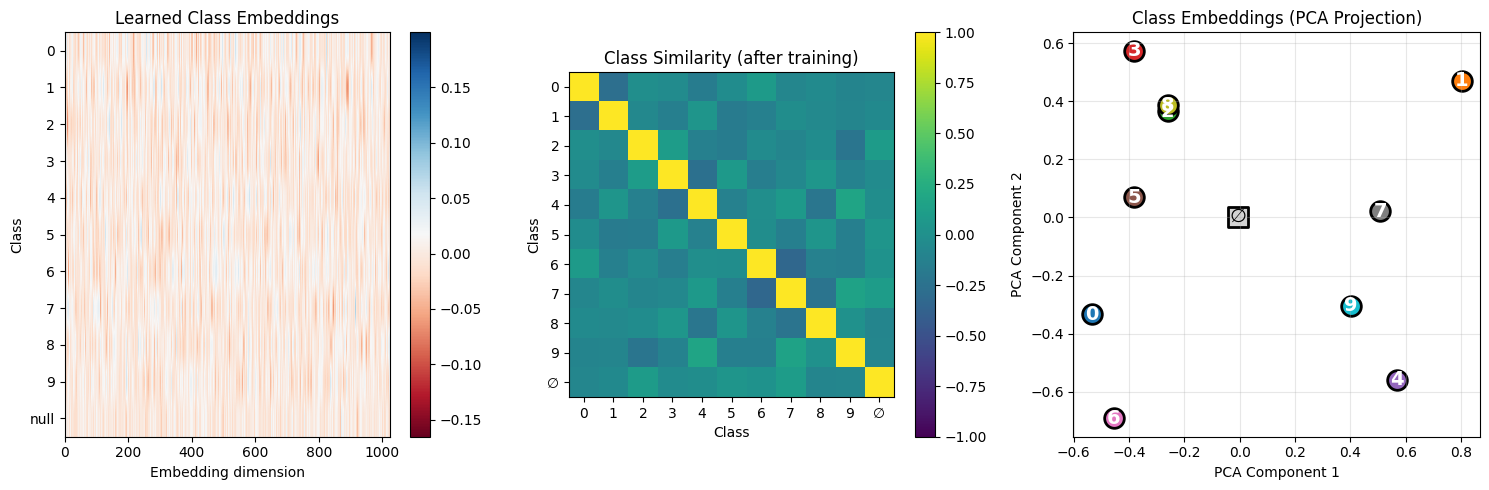


📊 Learned Embedding Analysis:
   • Similarity matrix shows which digits the model considers 'similar'
   • PCA projection shows the embedding space structure
   • The null class (∅) should be somewhat central/neutral


In [15]:
# Extract learned class embeddings
with torch.no_grad():
    learned_embeddings = model.class_embed.embed.weight.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Embedding matrix
im = axes[0].imshow(learned_embeddings, aspect='auto', cmap='RdBu')
axes[0].set_xlabel('Embedding dimension')
axes[0].set_ylabel('Class')
axes[0].set_yticks(range(11))
axes[0].set_yticklabels([str(i) for i in range(10)] + ['null'])
axes[0].set_title('Learned Class Embeddings')
plt.colorbar(im, ax=axes[0])

# 2. Similarity matrix
similarity = np.corrcoef(learned_embeddings)
im = axes[1].imshow(similarity, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Class')
axes[1].set_xticks(range(11))
axes[1].set_xticklabels([str(i) for i in range(10)] + ['∅'])
axes[1].set_yticks(range(11))
axes[1].set_yticklabels([str(i) for i in range(10)] + ['∅'])
axes[1].set_title('Class Similarity (after training)')
plt.colorbar(im, ax=axes[1])

# 3. 2D PCA projection using numpy SVD
def simple_pca(X, n_components=2):
    """Simple PCA using numpy SVD (no sklearn needed)."""
    X_centered = X - X.mean(axis=0)
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    return X_centered @ Vt.T[:, :n_components]

embeddings_2d = simple_pca(learned_embeddings, n_components=2)

for i in range(10):
    axes[2].scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], s=200, 
                   c=[plt.cm.tab10(i)], edgecolors='black', linewidths=2)
    axes[2].annotate(str(i), (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=14, ha='center', va='center', color='white', fontweight='bold')

# Plot null class differently
axes[2].scatter(embeddings_2d[10, 0], embeddings_2d[10, 1], s=200,
               c='lightgray', edgecolors='black', linewidths=2, marker='s')
axes[2].annotate('∅', (embeddings_2d[10, 0], embeddings_2d[10, 1]),
                fontsize=14, ha='center', va='center', color='black')

axes[2].set_xlabel('PCA Component 1')
axes[2].set_ylabel('PCA Component 2')
axes[2].set_title('Class Embeddings (PCA Projection)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Learned Embedding Analysis:")
print("   • Similarity matrix shows which digits the model considers 'similar'")
print("   • PCA projection shows the embedding space structure")
print("   • The null class (∅) should be somewhat central/neutral")

## Summary: Key Mathematical Concepts

### What We Built

We extended the DiT from Phase 2 with **class conditioning** and **Classifier-Free Guidance**.

### Key Equations Summary

| Concept | Equation |
|---------|----------|
| Class embedding | $e(y) = W_e[y] \in \mathbb{R}^D$ |
| Combined conditioning | $c = \text{TimeEmbed}(t) + e(y)$ |
| Label dropout (training) | $y_{\text{train}} \sim \text{Bernoulli}(1-p_{\text{drop}}) \cdot y + \text{Bernoulli}(p_{\text{drop}}) \cdot \emptyset$ |
| Training loss | $\mathcal{L} = \mathbb{E}\left[\|v_\theta(x_t, t, y_{\text{train}}) - (x_1 - x_0)\|^2\right]$ |
| **CFG formula** | $\boxed{v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})}$ |
| Alternative CFG form | $v_{\text{CFG}} = (1-w) \cdot v_{\text{uncond}} + w \cdot v_{\text{cond}}$ |

### Classifier-Free Guidance Derivation

Starting from Bayes' rule:
$$\nabla_x \log p(x \mid y) = \nabla_x \log p(x) + \nabla_x \log p(y \mid x)$$

The classifier gradient term $\nabla_x \log p(y \mid x)$ is implicitly learned as:
$$\nabla_x \log p(y \mid x) \propto v_{\text{cond}} - v_{\text{uncond}}$$

CFG amplifies this by factor $w$:
$$v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})$$

### Hyperparameter Recommendations

| Parameter | Typical Value | Effect |
|-----------|--------------|--------|
| Label dropout $p_{\text{drop}}$ | 0.1 | Enables CFG; higher = more unconditional training |
| CFG scale $w$ | 3-5 | Quality/diversity trade-off; higher = stronger conditioning |
| Embedding dim $D$ | 1024 | Same as conditioning dimension |

### Computational Considerations

| Phase | Model | Forward Passes/Step | Additional Params |
|-------|-------|---------------------|-------------------|
| 2 | DiT | 1 | - |
| 3 | ConditionalDiT | 2 (with CFG) | $(K+1) \times D$ |

## Looking Ahead: Phase 4

In Phase 4, we'll move from **class labels** to **text prompts**:

| Phase 3 | Phase 4 |
|---------|---------|
| $y \in \{0, \ldots, 9\}$ | $y = \text{"a photo of a cat"}$ |
| Embedding table $W_e$ | CLIP text encoder |
| Addition to timestep | Cross-attention |

The mathematical principles remain the same - we're just using richer conditioning!

In [16]:
# Optionally save the trained model
trainer.save_checkpoint("phase3_conditional_dit.pt")